In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, CategoricalParameter, Constant, ArrayOutcome
import time

ModuleNotFoundError: No module named 'visualize_placement'

In [2]:
## Load necessary data
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/revised_cleaning_results/ivs_exploded_100.p", "rb"))
path_lengths = pickle.load(open("data/revised_cleaning_results/path_lengths_ship_specific_routes.p", "rb"))
G = pickle.load(open('data/network_cleaned_final.p', 'rb'))
paths = pickle.load(open("data/final_paths.p", "rb"))

CPU times: total: 5.59 s
Wall time: 5.91 s


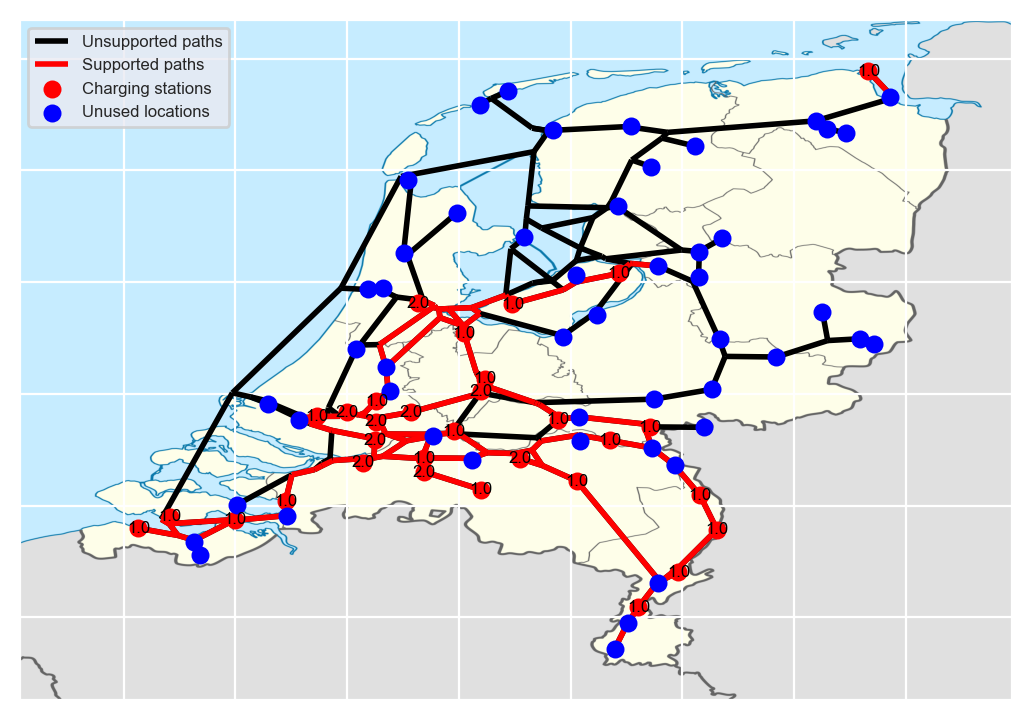

In [3]:
%%time
r = 90000
p = 40
c = 600
x_m = 2

total_flow, fraction_captured_total, serviceable_fraction, served_fraction, optimal_facilities, non_zero_flows, add_nodes_used = flow_refueling_location_model(r,p, c, x_m, additional_nodes=0, vis=True)

In [4]:
total_flow

2941841.1904762224

In [5]:
fraction_captured_total

0.13972594468462163

In [6]:
serviceable_fraction

0.2400578904128509

In [7]:
served_fraction

0.5820510396234897

## Works, now connect to workbench

### First run with non-random data

In [8]:
#define model
model = Model("frlm", function=flow_refueling_location_model)

In [9]:
model.uncertainties = [
    RealParameter("r", 50000, 150000),
]

# set levers
model.levers = [
    IntegerParameter("p", 10, 200),
    IntegerParameter("c", 500, 2500),
    IntegerParameter("x_m", 1, 5),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome('non_zero_flows'),
    ArrayOutcome("optimal_facilities"),
    ScalarOutcome('add_nodes_used'),
]

model.constants = [
    Constant("random_data", False),
]

In [10]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=10) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=20, policies=100)

C:\Users\Fabia\miniconda3\envs\ox\lib\site-packages\ema_workbench\em_framework\evaluators.py:349: UserWarning: the number of processes cannot be more then 20
  warnings.warn(
[MainProcess/INFO] pool started with 12 workers
[MainProcess/INFO] performing 20 scenarios * 100 policies * 1 model(s) = 2000 experiments
100%|████████████████████████████████████| 2000/2000 [1:05:13<00:00,  1.96s/it]
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


In [11]:
pickle.dump( experiments, open( "results/experiments_new20100.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_new20100.p", "wb") )
# experiments = pickle.load( open("results/experiments_new20100random.p", "rb"))
# outcomes = pickle.load( open("results/outcomes_new20100random.p", "rb"))

In [12]:
model.uncertainties = [
    RealParameter("r", 50000, 150000),
]

# set levers
model.levers = [
    IntegerParameter("p", 10, 200),
    IntegerParameter("c", 500, 2500),
    IntegerParameter("x_m", 1, 5),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome('non_zero_flows'),
    ArrayOutcome("optimal_facilities"),
    ScalarOutcome('add_nodes_used'),
]


model.constants = [
    Constant("random_data", True),
    Constant("seed", None),
]

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=20) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=20, policies=100)

[MainProcess/INFO] pool started with 20 workers
[MainProcess/INFO] performing 20 scenarios * 100 policies * 1 model(s) = 2000 experiments
 34%|█████████████▎                         | 684/2000 [24:46<57:59,  2.64s/it]

In [ ]:
pickle.dump( experiments, open( "results/experiments_new20100random.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_new20100random.p", "wb") )
# experiments = pickle.load( open("results/experiments_new20100random.p", "rb"))
# outcomes = pickle.load( open("results/outcomes_new20100random.p", "rb"))

## Also perform sobol

In [ ]:
model.uncertainties = [
    RealParameter("r", 50000, 150000),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 10, 200),
    IntegerParameter("station_cap", 500, 2500),
    IntegerParameter("max_per_loc", 1, 5),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ArrayOutcome('non_zero_flows'),
    ArrayOutcome("optimal_facilities"),
    ScalarOutcome('add_nodes_used'),
]

model.constants = [
    Constant("random_data", False),
]

In [ ]:
from SALib.analyze import sobol
from ema_workbench import Samplers
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(
        scenarios=1000, uncertainty_sampling=Samplers.SOBOL
    )

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_flow"], calc_second_order=True, print_to_console=False
)

In [ ]:
pickle.dump( experiments, open( "results/experiments_sobol.p", "wb" ) )
pickle.dump( outcomes, open("results/outcomes_sobol.p", "wb") )

In [ ]:
problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_flow"], calc_second_order=True, print_to_console=False
)

In [ ]:
scores_filtered = {k: Si[k] for k in ["ST", "ST_conf", "S1", "S1_conf"]}
Si_df = pd.DataFrame(scores_filtered, index=problem["names"])

sns.set_style("white")
fig, ax = plt.subplots(1)

indices = Si_df[["S1", "ST"]]
err = Si_df[["S1_conf", "ST_conf"]]

indices.plot.bar(yerr=err.values.T, ax=ax)
fig.set_size_inches(8, 6)
fig.subplots_adjust(bottom=0.3)
plt.show()

## Visualize results for each policy in a pairplot

In [ ]:
policies = experiments["policy"]
for i, policy in enumerate(np.unique(policies)):
    experiments.loc[policies == policy, "policy"] = str(i)

data = pd.DataFrame(outcomes)
data["policy"] = policies

In [ ]:
sns.pairplot(data, hue="policy", vars=list(outcomes.keys()))
plt.show()

## "Normal" pairplot?

In [ ]:
all_data = experiments.copy()
all_data['total_flow'] = outcomes['total_flow']
all_data['fraction_captured_total'] = outcomes['fraction_captured_total']
all_data['servicable_fraction'] = outcomes['servicable_fraction']
all_data['served_fraction'] = outcomes['served_fraction']
all_data['routes_supported'] = outcomes['routes_supported']

In [ ]:
all_data

In [ ]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

In [ ]:
sns.pairplot(all_data, vars=list(outcomes.keys()))
plt.show()

In [ ]:
sns.pairplot(all_data)

In [ ]:
all_data

In [ ]:
# all_data = all_data.loc[:, ['load','r', 'stations_to_place','total_flow','supported_fraction']]

In [ ]:
sns.pairplot(all_data, vars=list(outcomes.keys()))

In [ ]:
sns.pairplot(all_data)

## Visualize how results are correlated

In [ ]:
from ema_workbench.analysis import pairs_plotting

fig, axes = pairs_plotting.pairs_scatter(
    experiments, outcomes, group_by="policy", legend=False
)
fig.set_size_inches(8, 8)
plt.show()

In [ ]:
from ema_workbench.analysis import prim
%matplotlib inline
x = experiments
y = (1-outcomes["fraction_captured_total"]) < 0.7
prim_alg = prim.Prim(x, y, threshold=0.8)
box1 = prim_alg.find_box()

In [ ]:
box1.show_tradeoff()
plt.show()

In [ ]:
box1.inspect(10)
box1.inspect(10, style="graph")
plt.show()

In [ ]:
box1.show_pairs_scatter(10)
plt.show()

In [ ]:
from ema_workbench.analysis import feature_scoring

x = experiments
y = outcomes

fs = feature_scoring.get_feature_scores_all(x, y)
sns.heatmap(fs, cmap="viridis", annot=True)
plt.show()

In [ ]:
outcomes

In [ ]:
fs = feature_scoring.CHI2(x, y)

In [ ]:
fs

In [ ]:
from ema_workbench.analysis import dimensional_stacking

x = experiments
y = (1-outcomes["fraction_captured_total"]) < 0.7
dimensional_stacking.create_pivot_plot(x, y, 2, nbins=3)
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (1-outcomes["fraction_captured_total"]) < 0.7
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

In [ ]:
from ema_workbench.analysis import regional_sa
from numpy.lib import recfunctions as rf

sns.set_style("white")

# model is the same across experiments
x = experiments.copy()
x = x.drop("model", axis=1)
y = (outcomes["total_flow"]) < 1000
fig = regional_sa.plot_cdfs(x, y)
sns.despine()
plt.show()

## Sobol sampling

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import pickle
from fullfrlm import flow_refueling_location_model

## Load necessary data
G = pickle.load(open('data/cleaned_network.p', 'rb'))
df_h = pickle.load(open("data/harbour_data_100.p", "rb"))
df_ivs = pickle.load(open("data/ivs_exploded_100.p", "rb"))
paths = pickle.load(open("data/paths_ship_specific_routes.p", "rb"))
path_lengths = pickle.load(open("data/path_lengths_ship_specific_routes.p", "rb"))

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator
from SALib.analyze import sobol
from ema_workbench import Samplers, Model
from ema_workbench.em_framework.salib_samplers import get_SALib_problem

model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
from ema_workbench import IntegerParameter, RealParameter, Model, ScalarOutcome, ArrayOutcome

model = Model("frlm", function=flow_refueling_location_model)
#

# specify uncertainties
model.uncertainties = [
    RealParameter("load", 0, 1),
    IntegerParameter("r", 50000, 200000),
    IntegerParameter("stations_to_place", 1, 350),
    IntegerParameter("station_cap", 1, 5),
    IntegerParameter("max_per_loc", 1, 5)
]

# set levers
# model.levers = [
#     IntegerParameter("stations_to_place", 1, 350),
#     IntegerParameter("station_cap", 1, 5),
#     IntegerParameter("max_per_loc", 1, 5),
# ]

# specify outcomes
model.outcomes = [
    ScalarOutcome("total_flow"),
    ScalarOutcome("supported_fraction"),
]

In [ ]:
with MultiprocessingEvaluator(model) as evaluator:
    sa_results = evaluator.perform_experiments(scenarios=1000, uncertainty_sampling=Samplers.SOBOL)

In [ ]:
pickle.dump( sa_results, open( "results/sa_1000.p", "wb" ) )

In [ ]:

experiments, outcomes = sa_results

problem = get_SALib_problem(model.uncertainties)
Si = sobol.analyze(
    problem, outcomes["supported_fraction"], calc_second_order=True, print_to_console=False
)

## Nice figure with increasing stations vs flow captured?

In [ ]:
# define model
model = Model("frlm", function=flow_refueling_location_model)

In [ ]:
model.uncertainties = [
    IntegerParameter("max_per_loc", 1, 3),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 1, 100),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("supported_flow"),
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
]

model.constants = [
    Constant("random_data", False),
    Constant("seed", None),
    Constant("r", 90000),
    Constant("load", 1),
    Constant("v", 3.0830*3.6*1000),
    Constant("p_b", 175),
    Constant("o", 24),
    Constant("station_cap", 1000),
]

In [ ]:
from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=20) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=3, policies=100)

In [ ]:
df_out = pd.DataFrame(outcomes)

In [ ]:
df_total = pd.merge(experiments,df_out,left_index=True,right_index=True)

In [ ]:
df_total

In [ ]:
sns.scatterplot(data=df_total, x='stations_to_place',y='served_fraction', hue='max_per_loc')

## Various ranges and fixed station cap (3)

In [ ]:
model.uncertainties = [
    CategoricalParameter("r", [60000, 90000, 120000]),
]

# set levers
model.levers = [
    IntegerParameter("stations_to_place", 1, 100),
]

# specify outcomes
model.outcomes = [
    ScalarOutcome("supported_flow"),
    ScalarOutcome("total_flow"),
    ScalarOutcome("fraction_captured_total"),
    ScalarOutcome("serviceable_fraction"),
    ScalarOutcome("served_fraction"),
    ScalarOutcome("routes_supported"),
]

model.constants = [
    Constant("random_data", False),
    Constant("seed", None),

    Constant("load", 1),
    Constant("v", 3.0830 * 3.6 * 1000),
    Constant("p_b", 175),
    Constant("o", 24),
    Constant("station_cap", 1000),
    Constant("max_per_loc", 3),
]

In [ ]:

from ema_workbench import MultiprocessingEvaluator, SequentialEvaluator, ema_logging, perform_experiments

ema_logging.log_to_stderr(ema_logging.INFO)

with MultiprocessingEvaluator(model, n_processes=20) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=3, policies=100)

In [ ]:
df_out = pd.DataFrame(outcomes)
df_total = pd.merge(experiments, df_out, left_index=True, right_index=True)
df_total
sns.scatterplot(data=df_total, x='stations_to_place', y='supported_flow', hue='r')